In [1]:
patid = '231'

In [4]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble
import seaborn as sns
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

In [5]:



features_list = ['theta', 'alpha','beta', 'high_gamma']
plot_3d_var_list = ['high_gamma3', 'high_gamma4','beta4']


## 1. Data loading

### What the data looks like

In [19]:
import pickle
data = pickle.load( open( "../data/ml_ready_data.p", "rb" ) )
# remove outliers
data = JJ.remove_outliers(data)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

data

filename          region_start_time      delta1      delta2  \
86   1.309997e+17 2016-02-14 03:59:36.960000   61.166778  273.677298   
87   1.310015e+17 2016-02-15 20:59:18.960000   40.548973  773.155101   
88   1.310019e+17 2016-02-16 20:59:12.998400   41.771439  172.179808   
89   1.310032e+17 2016-02-18 03:58:56.006400   42.171886  290.146546   
90   1.310041e+17 2016-02-19 03:58:42.960000   45.669293  290.906731   
..            ...                        ...         ...         ...   
884  1.316288e+17 2018-02-11 15:51:35.971200  104.142656   43.925946   
885  1.316296e+17 2018-02-11 21:51:24.998400  113.162000   50.395396   
886  1.316296e+17 2018-02-12 03:51:23.011200  225.536331  153.708886   
887  1.316296e+17 2018-02-12 09:51:21.974400   85.753303   34.006378   
888  1.316296e+17 2018-02-12 15:51:21.024000   78.690558   35.500397   

         delta3      ...        i34  epoch  label  patid  if_stimulated  
86    33.567358      ...        0.0      0   True  222_1          False  
87    25.976912      ...        0.0      0   True  222_1          False  
88    32.841170      ...        0.0      0   True  222_1          False  
89    36.623015      ...        0.0      0   True  222_1          False  
90    25.191819      ...        0.0      0   True  222_1          False  
..          ...      ...        ...    ...    ...    ...            ...  
884  121.402267      ...        1.0     11  False    231           True  
885   91.166914      ...        1.0     11  False    231           True  
886  189.820605      ...        8.0     11  False    231           True  
887  103.498303      ...        0.0     11  False    231           True  
888   83.216243      ...        0.0     11  False    231           True  

[2153 rows x 36 columns]

In [43]:
np.set_printoptions(suppress=True)

pd.set_option('display.max_rows', 50)
data_sp = JJ.select_data(data,select_dict = {'patid':'231', 'label':False, 'if_stimulated': True}, keep_list = ['label','patid','filename', 'high_gamma4','if_stimulated'])
a = data_sp.sort_values(by=['high_gamma4'])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(a)
#for item in a:
#    print('{0:f}'.format(item))

     label patid               filename  high_gamma4  if_stimulated
734  False   231 131510329427210000.000       19.190           True
635  False   231 131453321574850000.000       19.806           True
638  False   231 131454186483470000.000       19.973           True
610  False   231 131432593100570000.000       20.217           True
731  False   231 131509478067330000.000       20.257           True
624  False   231 131442082580040000.000       20.280           True
735  False   231 131512203508400000.000       20.294           True
616  False   231 131437753552670000.000       20.339           True
728  False   231 131508637440530000.000       20.462           True
640  False   231 131455916561670000.000       20.499           True
720  False   231 131498278507510000.000       20.568           True
597  False   231 131425676030230000.000       20.707           True
584  False   231 131422385615600000.000       21.251           True
741  False   231 131516433434220000.000       21

## 2. Building Classifiers
### Fitting 7 classfier to the training data and tune the hyperparameter using 10-fold cross-validation. Evaluate the performance of each classifier using test data

### 1:'Logistic Regression' (regulation type, regulation parameter)
### 2: 'SVM' (kernel type, degreee, regulation type, regulation parameter)
### 3: 'Gaussian Naive Bayes classifier'
### 4:'Linear Discriminant Analysis'
### 5:'Decision Tree' (criterion for splliting, max depth, min sample per leaf)
### 6:'Random Forest' (criterion for splliting, number of trees, number of features used in each  tree, max depth, min sample per leaf)
### 7:'Gradient Boosting' (number of estimator, number of samples used in each estimator, max depth, min sample per leaf, learning rate)

## 3. Classifier Performance

### Performace Overview of each Classifier

In [11]:
X_train, X_test, y_train, y_test = JJ.get_ml_data(data, patid, if_scaler = 1, if_remove_icd = 1)

JJ.scores_estimators(X_test, y_test, patid = patid)

Classifier       AUC
0    gradient boosting  0.842561
1        random forest  0.831488
2                  SVM  0.827957
3        decision tree  0.808538
4  Logistic Regression  0.793773

Classifier  Accuracy
0    gradient boosting   0.82500
1        random forest   0.78750
2                  SVM   0.78125
3  Logistic Regression   0.76250
4        decision tree   0.75000

### The confusion matrix and ROC of Gradient Boosting (the best classifier in this case)

Confusion matrix, without normalization


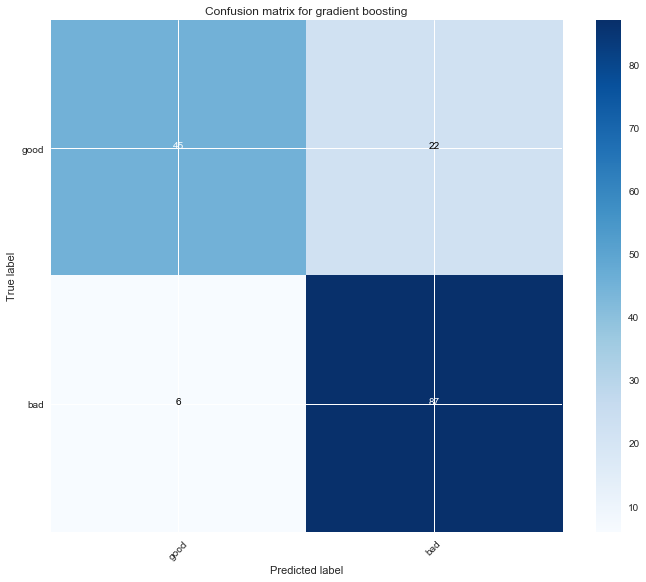

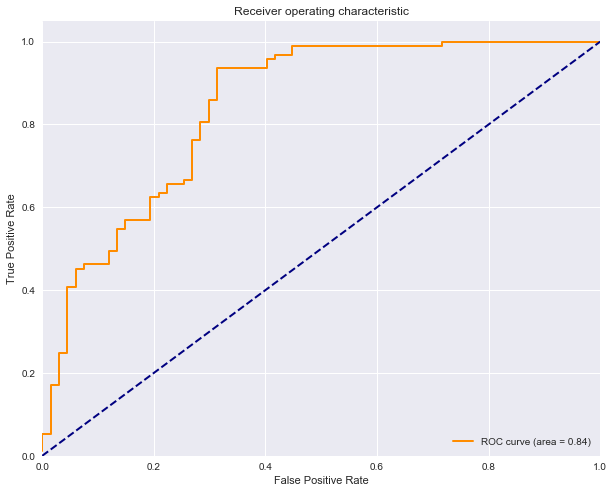

In [12]:
X_train, X_test, y_train, y_test = JJ.get_ml_data(data, patid, if_scaler = 1, if_remove_icd = 1)

JJ.estimator_performance(7, X_test, y_test, patid = patid, if_plot_c = 1, if_plot_roc = 1)

### ROC curve for all classifiers

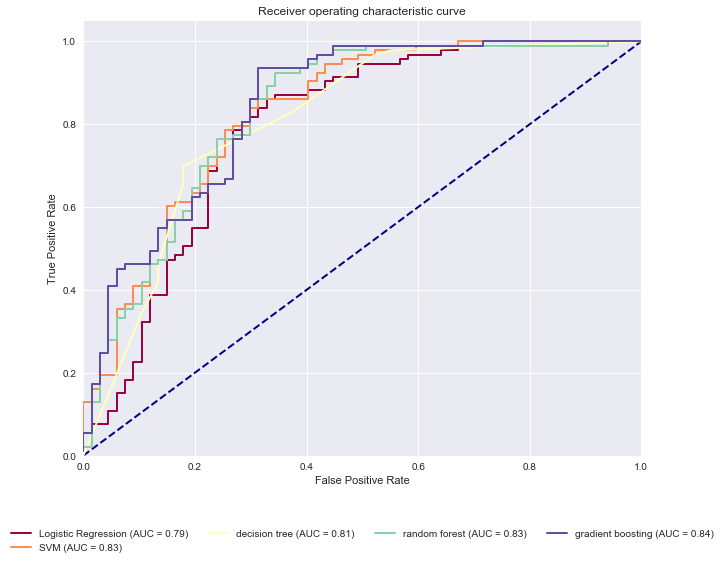

In [13]:
JJ.plot_roc_all(X_test, y_test, patid = patid)

### Ensemble SVM, Logistic Regression, Random Forest and Gradient Boosting using hard vote

In [15]:

X_train, X_test, y_train, y_test = JJ.get_ml_data(data, patid, if_scaler = 1, if_remove_icd = 1)
#parameter_tuning(X_train, X_test, y_train, y_test, classifier = 1, C_range_num = 100, if_save = 1)

print("The accuracy for ensemble model is")
JJ.ensemble_model(X_train, y_train, X_test, y_test, patid = patid,if_save = 0)

The accuracy for ensemble model is
0.825


## 4. Feature Importance

### Feature Importance for Logistic regression

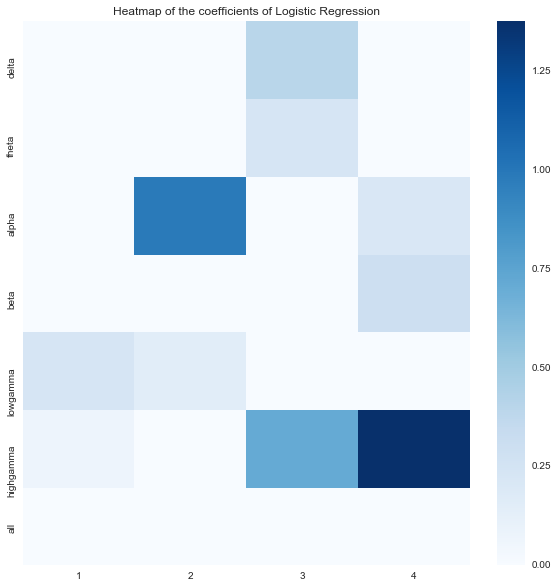

In [16]:
import matplotlib.pyplot as plt

prepath = '../estimators/'+patid + '/'
classifier_int = 1
int2name = {1:'Logistic Regression', 2: 'SVM', 3: 'Gaussian Naive Bayes classifier', 4:'Linear Discriminant Analysis', 5:'decision tree', 6:'random forest', 7:'gradient boosting'}
clf_name = int2name[classifier_int]
clf = pickle.load(open(prepath + 'best_estimator_for_' + str(clf_name) + '.p', "rb" ))
coef = np.abs(clf.coef_.reshape(7,4))
powerband = ['delta', 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma', 'all'][::-1]
channel = ['1', '2', '3', '4']
df = pd.DataFrame(coef, index = powerband, columns = channel)
import seaborn as sns
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(10,10))
r = sns.heatmap(coef, cmap = "Blues")
r.set_title("Heatmap of the coefficients of {}".format(clf_name))
ax.set_yticklabels(df.index)
ax.set_xticklabels(df.columns)
plt.show()

### Feature Importance for Gradient Boosting

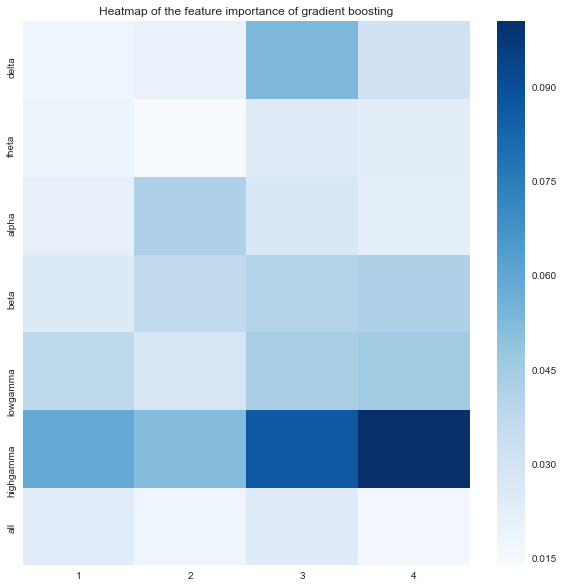

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
prepath = '../estimators/'+patid + '/'
classifier_int = 7
int2name = {1:'Logistic Regression', 2: 'SVM', 3: 'Gaussian Naive Bayes classifier', 4:'Linear Discriminant Analysis', 5:'decision tree', 6:'random forest', 7:'gradient boosting'}
clf_name = int2name[classifier_int]
clf = pickle.load(open(prepath + 'best_estimator_for_' + str(clf_name) + '.p', "rb" ))
coef = np.abs(clf.feature_importances_.reshape(7,4))
powerband = ['delta', 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma', 'all'][::-1]
channel = ['4', '3', '2', '1'][::-1]
df = pd.DataFrame(coef, index = powerband, columns = channel)
import seaborn as sns
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(10,10))
r = sns.heatmap(coef, cmap = "Blues")
r.set_title("Heatmap of the feature importance of {}".format(clf_name))
ax.set_yticklabels(df.index)
ax.set_xticklabels(df.columns)
sns.plt.show()

## 5. Data visualization

## Pairwise features scatter plot

### Each data point corresponds to a .dat file. Red points means it is in a good epoch, and blue points means it is in a bad epoch.

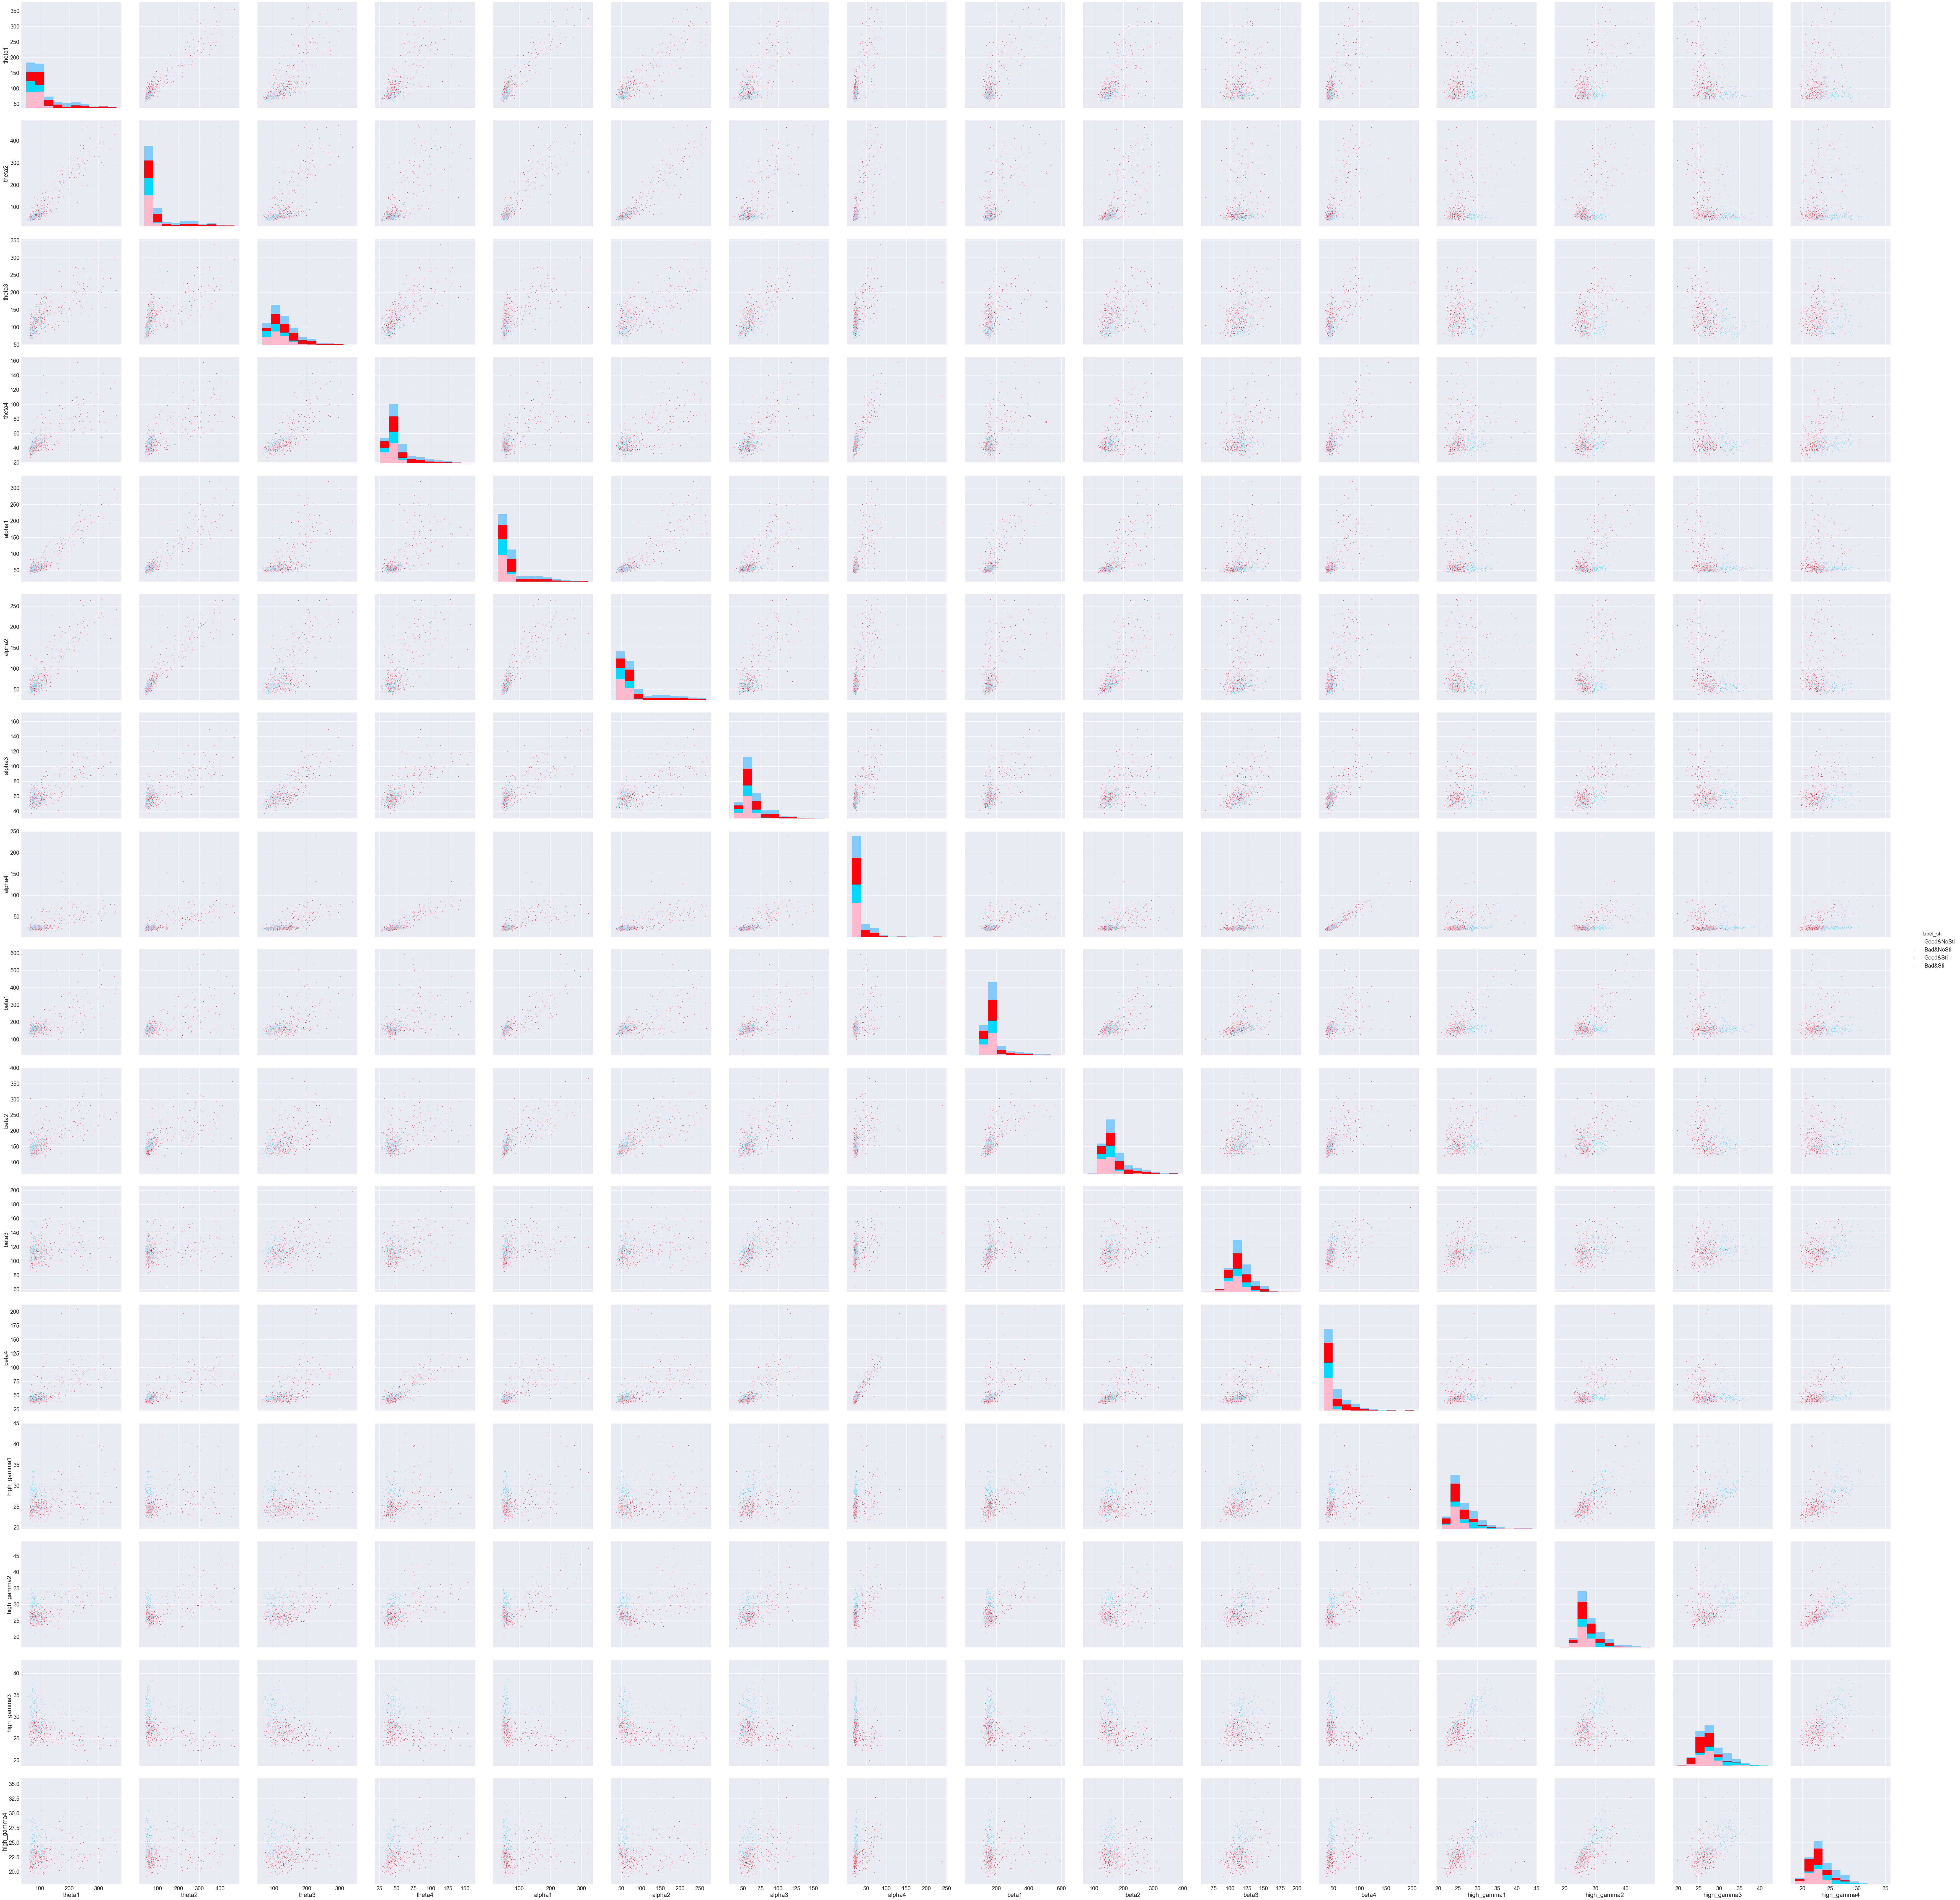

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data_ml = JJ.get_scatter_plot_data(data, patid)
sns.set(font_scale=2)
colors = ["baby pink", "neon blue", "bright red", "sky"]
#sns.pairplot(data_ml, hue="label_sti", size = 5, vars=JJ.get_variable_name(features_list), plot_kws={"s": 5},palette=sns.diverging_palette(240, 10, n=4))
g = sns.pairplot(data_ml, hue="label_sti", size = 6, vars=JJ.get_variable_name(features_list), plot_kws={"s": 5},palette=sns.xkcd_palette(colors))
plt.savefig('../fig/scatter_231.png')
plt.show()

### 3D scatter plot

<IPython.core.display.Javascript object>


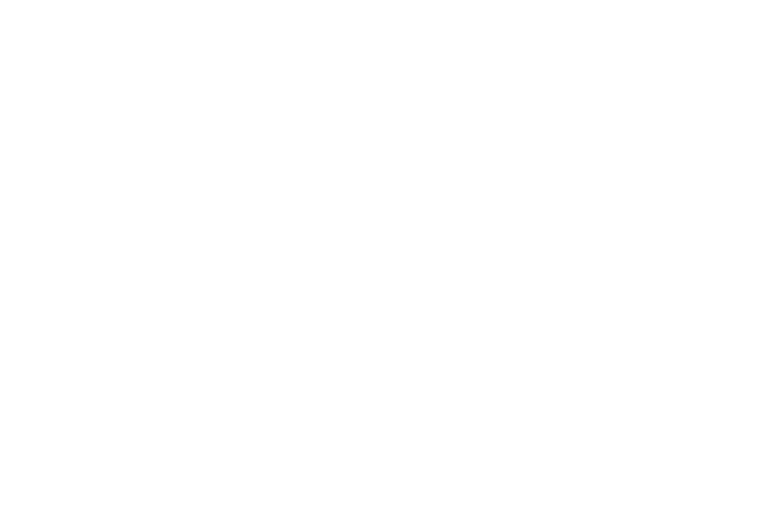

<IPython.core.display.Javascript object>


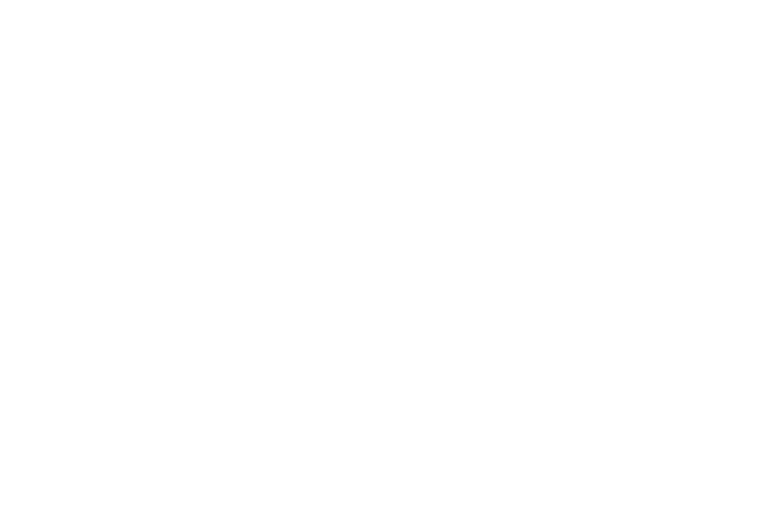

In [12]:
%matplotlib notebook

JJ.scatter_plot_3d(data,patid, var_list = plot_3d_var_list)
